# Evaluate the boundary model's calibration

__Objective:__ evaluate whether the confidence scores outputted (verbally) by the boundary classifier are somehow "calibrated" to the samples. I.e.: is the model more sure of its prediction if the sample is more clearly hateful/non-hateful?

Idea:
1. Take the boundary model's predictions, but this time go back and fetch the original toxic scores (in the 0-4 range).
2. Identify more difficult samples to classify as the ones that have a higher standard deviations in their toxic scores (either the original ones or the binarized ones).
3. Correlate samples' difficulty with the boundary model's confidence score.

**Notes:**
- The original toxic scores are per-annotator, while the boundary model's predictions are purely on the texts: some aggregation might be needed on the original toxic score side (average over annotators?).
- The boundary model doesn't know anything about the binarized labels (we used a zero-shot setting), but its performance has been computed with them as gold labels. Should we avoid considering "wrong" predictions when evaluating calibration? Should we consider again binarization (after averaging over annotators?) to dub a prediction wrong?
- File paths/versions/etc. are the ones in the `load_all_predictions.ipynb` notebook and are checked.

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

sns.set_theme()

In [2]:
KUMAR_TEST_DATA_SUBSAMPLED_PATH = '/data1/moscato/personalised-hate-boundaries-data/models/sepheads_model_training_test_subsampling_2/test_data_subsampled.csv'
BOUNDARY_MODEL_PREDS_KUMAR_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/boundary_model_predictions/paul_kumar_fullpredictions.csv'

KUMAR_ANNOTATORS_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/annotators_data.csv'

KUMAR_ORIGINAL_FULL_DATA_PATH = '/data1/moscato/personalised-hate-boundaries-data/data/kumar_perspective_clean/kumar_processed_with_ID_and_full_perspective_clean.csv'

In [3]:
# Load the Kumar subsampled test split used to evaluate SepHeads.
kumar_test_data_subsampled = pd.read_csv(KUMAR_TEST_DATA_SUBSAMPLED_PATH)

# Load the annotators data.
kumar_annotators_data = pd.read_csv(KUMAR_ANNOTATORS_DATA_PATH)

# Join Kumar subsampled test split with annotators data.
kumar_test_data_subsampled = pd.merge(
    left=kumar_test_data_subsampled,
    right=kumar_annotators_data[['annotator_id', 'extreme_annotator']],
    how='left',
    on='annotator_id'
)


# Load the boundary model's predictions for Kumar's test data.
boundary_model_preds_kumar = pd.read_csv(BOUNDARY_MODEL_PREDS_KUMAR_PATH)[['text_id', 'prediction', 'confidence_score']].rename(
    columns={'prediction': 'boundary_model_predicted_toxic_score', 'confidence_score': 'boundary_model_confidence_score'}
)


# Load the full Kumar dataset, before train-test split, subsampling and labels binarization.
kumar_full_data_original = pd.read_csv(KUMAR_ORIGINAL_FULL_DATA_PATH)[
    ['text_id', 'worker_id', 'toxic_score']
].rename(columns={'toxic_score': 'toxic_score_original'})

/tmp/ipykernel_3116/4066439461.py:23: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  kumar_full_data_original = pd.read_csv(KUMAR_ORIGINAL_FULL_DATA_PATH)[


Join data to get the original toxic scores along with the binarized ones and the boundary model's predictions and confidence scores.

In [86]:
kumar_test_data_subsampled_boundary_pred_original_toxic_score = pd.merge(
    left=pd.merge(
        left=kumar_test_data_subsampled,
        right=boundary_model_preds_kumar,
        how='left',
        on='text_id'
    ),
    right=kumar_full_data_original,
    on=['text_id', 'worker_id'],
    how='left'
)

# WARNING: subsampling to (binarized) hateful class only.
# kumar_test_data_subsampled_boundary_pred_original_toxic_score = kumar_test_data_subsampled_boundary_pred_original_toxic_score[
#     kumar_test_data_subsampled_boundary_pred_original_toxic_score['toxic_score'] > 0
# ]

kumar_test_data_subsampled_boundary_pred_original_toxic_score

,comment,text_id,worker_id,toxic_score,annotator_id,extreme_annotator,boundary_model_predicted_toxic_score,boundary_model_confidence_score,toxic_score_original
0,#AtoZQuiz A05 Bar [any mention of baa],5,dbc501198ada6725d8e8cc6f0101824f04d4b4b8935059...,0,1,False,0,90,0
1,#AtoZQuiz A05 Bar [any mention of baa],5,29a3513367445e0fd3c53d61da1fcbebbf4efc6e0de0b9...,0,2,False,0,90,0
2,#AtoZQuiz A05 Bar [any mention of baa],5,26523080557217fc3b42c882aecab5863966ccfbe31c3f...,0,3,False,0,90,0
3,Robert Manion????HA!More like ROBER manion bcs...,11,dbc501198ada6725d8e8cc6f0101824f04d4b4b8935059...,0,1,False,0,90,0
4,Robert Manion????HA!More like ROBER manion bcs...,11,29a3513367445e0fd3c53d61da1fcbebbf4efc6e0de0b9...,0,2,False,0,90,0
...,...,...,...,...,...,...,...,...,...
35442,Same. Jesus Christ he’s been horrible this year,105986,8bcb34d67e6969f6e2c3f4d96db021ea3bedb73831522e...,1,3024,False,0,90,1
35443,Same. Jesus Christ he’s been horrible this year,105986,50d355ebffb4a40ef84da9137b206ac3a54b00bcc94b6c...,1,10446,False,0,90,1
35444,Last time I checked they don't measure radiati...,105992,93bb39808c33e806cf7fc28190caeca8662561dca6ca2a...,0,640,False,0,95,0
35445,Last time I checked they don't measure radiati...,105992,8bcb34d67e6969f6e2c3f4d96db021ea3bedb73831522e...,0,3024,False,0,95,0


Aggregation: averaging over annotators (both for the original and the binarized toxic score).

In [87]:
# Average over annotators.
aggregated_eval_data = kumar_test_data_subsampled_boundary_pred_original_toxic_score.groupby('text_id').agg(
    mean_toxic_score_original=pd.NamedAgg('toxic_score_original', 'mean'),
    std_toxic_score_original=pd.NamedAgg('toxic_score_original', 'std'),
    mean_toxic_score=pd.NamedAgg('toxic_score', 'mean'),
    std_toxic_score=pd.NamedAgg('toxic_score', 'std'),
    boundary_model_predicted_toxic_score=pd.NamedAgg('boundary_model_predicted_toxic_score', 'first'),
    boundary_model_confidence_score=pd.NamedAgg('boundary_model_confidence_score', 'first'),
).reset_index()

# Exclude wrong predictions.
aggregated_eval_data = aggregated_eval_data[
    ~(
        (aggregated_eval_data['mean_toxic_score_original'] > 0.)
        & (aggregated_eval_data['boundary_model_predicted_toxic_score'] == 0.)
    )
    & ~(
        (aggregated_eval_data['mean_toxic_score_original'] == 0.)
        & (aggregated_eval_data['boundary_model_predicted_toxic_score'] == 1)
    )
].reset_index(drop=True)

aggregated_eval_data

,text_id,mean_toxic_score_original,std_toxic_score_original,mean_toxic_score,std_toxic_score,boundary_model_predicted_toxic_score,boundary_model_confidence_score
0,5,0.000000,0.000000,0.0,0.000000,0,90
1,11,0.000000,0.000000,0.0,0.000000,0,90
2,15,0.000000,0.000000,0.0,0.000000,0,85
3,16,2.333333,1.527525,1.0,0.000000,1,95
4,17,0.000000,0.000000,0.0,0.000000,0,95
...,...,...,...,...,...,...,...
9951,105907,0.000000,NaN,0.0,NaN,0,85
9952,105912,0.000000,NaN,0.0,NaN,0,85
9953,105915,0.000000,NaN,0.0,NaN,0,85
9954,105927,1.000000,1.414214,0.5,0.707107,1,95


Evaluation: standard deviation of the original toxic score VS boundary model's confidence score.

Text(0, 0.5, 'Value')

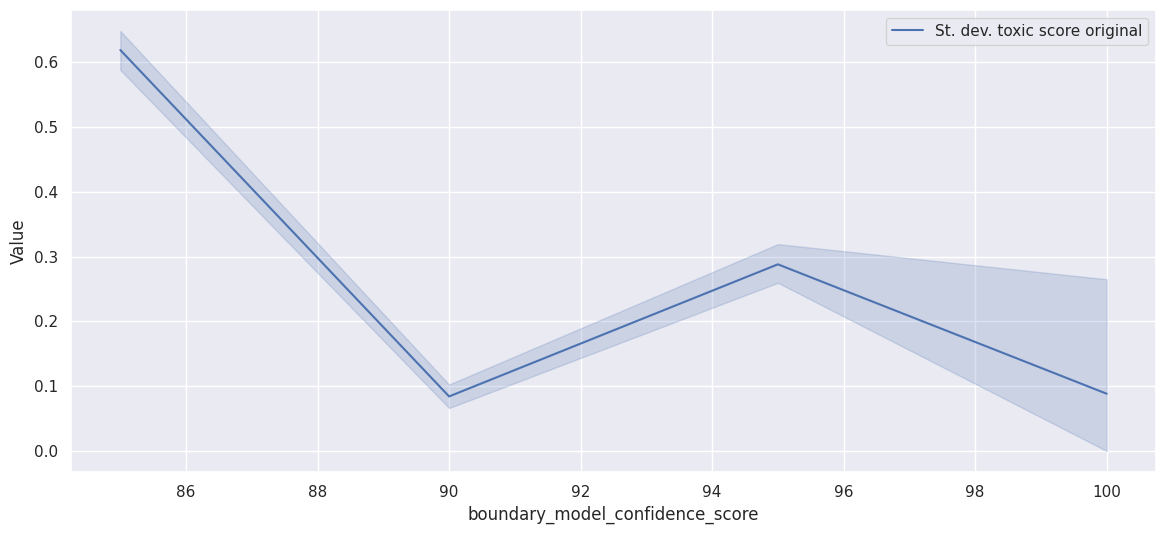

In [96]:
fig = plt.figure(figsize=(14, 6))

# sns.lineplot(
#     data=aggregated_eval_data,
#     x='boundary_model_confidence_score',
#     y='mean_toxic_score_original',
#     label='Mean toxic score original'
# )

sns.lineplot(
    data=aggregated_eval_data,
    x='boundary_model_confidence_score',
    y='std_toxic_score_original',
    label='St. dev. toxic score original'
)

plt.ylabel('Value')

Evaluation: standard deviation of the binrized toxic score VS boundary model's confidence score.

Text(0, 0.5, 'Value')

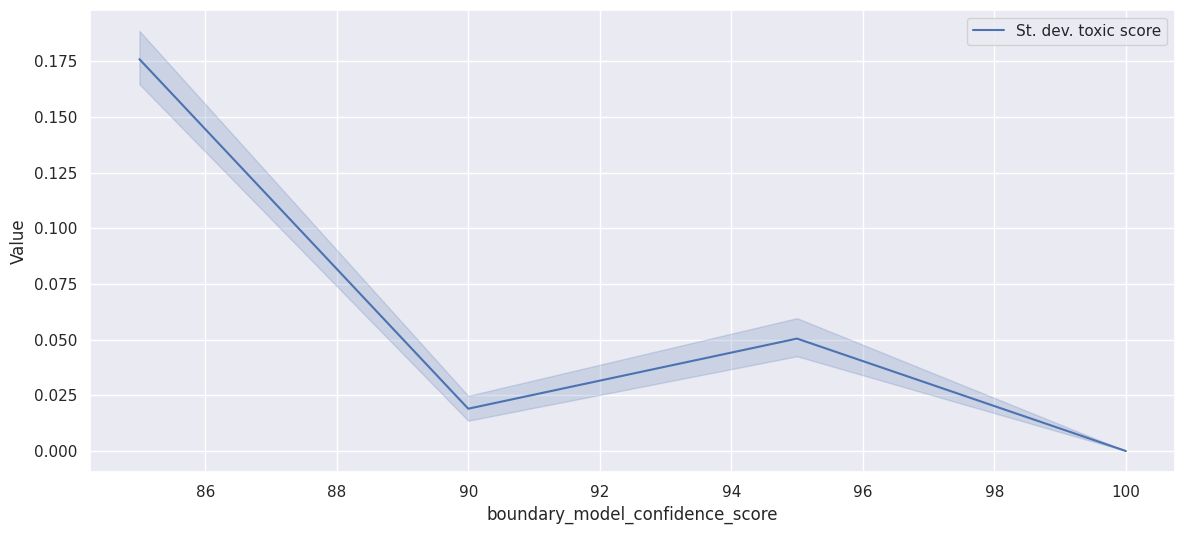

In [99]:
fig = plt.figure(figsize=(14, 6))

sns.lineplot(
    data=aggregated_eval_data,
    x='boundary_model_confidence_score',
    y='std_toxic_score',
    label='St. dev. toxic score'
)

plt.ylabel('Value')

In [100]:
aggregated_data_std = aggregated_eval_data.groupby('boundary_model_confidence_score').agg(
    std_toxic_score=pd.NamedAgg('std_toxic_score', 'mean'),
    count=pd.NamedAgg('std_toxic_score', 'count')
).reset_index()

pearsonr(
    x=aggregated_data_std['boundary_model_confidence_score'],
    y=aggregated_data_std['std_toxic_score']
)

PearsonRResult(statistic=-0.8092562940617285, pvalue=0.1907437059382715)

In [101]:
aggregated_data_std

,boundary_model_confidence_score,std_toxic_score,count
0,85,0.175998,2301
1,90,0.018988,1447
2,95,0.050484,1674
3,100,0.000000,16
